# ASSET RISK ASSESSMENT USING QUANTUM PHASE ESTIMATION

Using **Quantum Phase Estimation (QPE)** we will be analyze the availiable assets for **Level of risk** on a covariance matrix of asset returns. As part of the project we will be:
1. Import real life asset using yfinance.
2. Compute covariance matrix of returns and perform classical eigen-decomposition.
3. Encode the covariance matrix as a quantum unitary.
4. Buld a QPE circuit.
5. Simulate QPE to estimate the largest eigenvalue.
6. Analyze and visualize individual asset risk contributions.

## Step 0: Prequistes

Make sure that **`yfinance`**, **`scipy`**, **`pands`** are installed in the environment.

I have added pip install of **`yfinance`** as part of the code.

In [ ]:
#!pip install -q yfinance

In [23]:
import yfinance
import numpy
import pandas
import scipy
import qiskit
import qiskit_aer
import matplotlib
import sys

print("Python version:", sys.version)
print("yfinance version:", yfinance.__version__)
print("numpy version:", numpy.__version__)
print("pandas version:", pandas.__version__)
print("scipy version:", scipy.__version__)
print("qiskit version:", qiskit.__version__)
print("qiskit-aer version:", qiskit_aer.__version__)
print("matplotlib version:", matplotlib.__version__)

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
yfinance version: 0.2.66
numpy version: 2.0.2
pandas version: 2.2.2
scipy version: 1.16.3
qiskit version: 2.2.3
qiskit-aer version: 0.17.2
matplotlib version: 3.10.0


## Step 1: Libraries

- **`yfinance`**: download stock prices  
- **`numpy`** and **`pandas`**: numerical and tabular data manipulation
- **`scipy.linalg.eigh`**: classical eigenvalues and eigenvectors
- **`scipy.linalg.expm`**: exponentiate matrix for quantum simulation
- **`qiskit`**: build and simulate quantum circuits
- **`matplotlib`**: visualize results

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.linalg import eigh, expm
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import UnitaryGate
import matplotlib.pyplot as plt

## Step 2: Import Asset Data

**`yfinanace`** is a library that provides an easy way to connect to Yahoo Finance to download and import financial data directly. For this project to we will be using 10 assets to keep computational time resonabel but it can be scaled depending on the requirement.

**`n_count`** is a variable to control the precision of eigenvalue. The resolution is calculated as `1 / 2^n_count`

**`dropna()`** is a simple function that removes any missing data row

**`pct_change()`** computes daily percentage returns from price data.

**`cov()`** computes the sample covariance matrix of the return series.

The covariance matrix Σ captures how asset returns move together.
In risk analysis, the **dominant eigenvalue** of *Sigma* (Σ) corresponds to the direction of **maximum variance**, and its eigenvector shows the composition of that risk.

This matrix will later serve as the operator whose eigenvalues we estimate using Quantum Phase Estimation (QPE).

In [3]:
tickers = ['AAPL','MSFT','GOOGL','AMZN','TSLA','NVDA','META','IBM','ORCL','INTC']  # Example 10 assets
n_count = 12  # Counting qubits for QPE

In [4]:
data = yf.download(tickers, start='2023-01-01', end='2023-11-01', auto_adjust=True)['Close']
data = data.dropna()

[*********************100%***********************]  10 of 10 completed


In [5]:
returns = data.pct_change().dropna()
Sigma = returns.cov().values

## Step 3: Classical Eigen-Decomposition for Benchmarking

**`eigh()`** computes eigenvalues and eigenvectors of a Hermitian matrix efficiently.

The largest eigenvalue of Σ represents the **highest level of risk**, while the remaining eigenvector gives asset contribution weights.

This classical method of calculating eigenvector is used for purely benchmarking purposes.

In [6]:
n_assets = Sigma.shape[0]
n_system_qubits = int(np.ceil(np.log2(n_assets)))
dim = 2**n_system_qubits
Sigma_padded = np.zeros((dim, dim))
Sigma_padded[:n_assets, :n_assets] = Sigma

In [7]:
eigvals, eigvecs = eigh(Sigma_padded)
dominant_eigval = eigvals[-1]
dominant_eigvec = eigvecs[:, -1]
print("Classical largest eigenvalue:", dominant_eigval)

Classical largest eigenvalue: 0.0025369668614505384


## Step 4: Build Unitary Operator for QPE

**`expm()`** computes the matrix exponential

For QPE, the target operator must be unitary. We therefore create:

$U = e^{2\pi j \Sigma}$

This unitary has eigenvectors identical to Σ, but the eigenvalues are encoded as phases $e^{2\pi i \lambda}$.

QPE will recover the phase corresponding to the dominant eigenvalue of Σ.

In [8]:
U_padded = expm(2j * np.pi * Sigma_padded)

## Step 5: Build Quantum Circuit for QPE

Quantum Phase Estimation Circuit (Source: Pennylane.ai)
<p align="center">
  <img src="https://blog-assets.cloud.pennylane.ai/demos/tutorial_qpe/main/_assets/images/qpe.png" alt="QPE Circuit Diagram" width="45%">
</p>

According to the given circuit we build our quantum circuit as well.

For Controlled-U operations - $U^{2^0}, U^{2^1}, U^{2^2}, \ldots, U^{2^{n-1}}$ , we use following:

**`np.linalg.matrix_power(U, power)`** computes \(U^{2^j}\)

**`UnitaryGate(U_power)`** wraps a matrix as a quantum gate.

**`.control()`** converts it into a controlled gate.

**`qc.append(...)`** inserts the controlled-U operations acting on:
  - a single counting qubit (control)
  - all system qubits (target)

These controlled unitaries store the eigenvalue phase into the counting qubits through phase kickback.

The final part of the circuit is the quantum fourier transform.This functions recovers the encoded eigenvalue.

The function `qft_dagger(n)` constructs QFT manually:

**`swap` gates** reverse qubit order.

**`qc.cp(angle, k, j)`** controlled phase rotations implementing the Fourier phases.

**`qc.h(j)`** final Hadamard transformations.

In [9]:
qc = QuantumCircuit(n_count + n_system_qubits, n_count)

# Initialize dominant eigenvector on system qubits
qc.initialize(dominant_eigvec, list(range(n_count, n_count + n_system_qubits)))

# Apply Hadamard to counting qubits
qc.h(range(n_count))

# Controlled-U operations (powers of U)
for j in range(n_count):
    U_power = np.linalg.matrix_power(U_padded, 2**j)
    U_gate = UnitaryGate(U_power)
    qc.append(U_gate.control(), [j] + list(range(n_count, n_count + n_system_qubits)))

# Inverse QFT
def qft_dagger(n):
    qc_qft = QuantumCircuit(n)
    for j in range(n//2):
        qc_qft.swap(j, n-j-1)
    for j in range(n):
        for k in range(j):
            qc_qft.cp(-np.pi/2**(j-k), k, j)
        qc_qft.h(j)
    return qc_qft

qc.append(qft_dagger(n_count), range(n_count))

# Measure counting qubits
qc.measure(range(n_count), range(n_count))

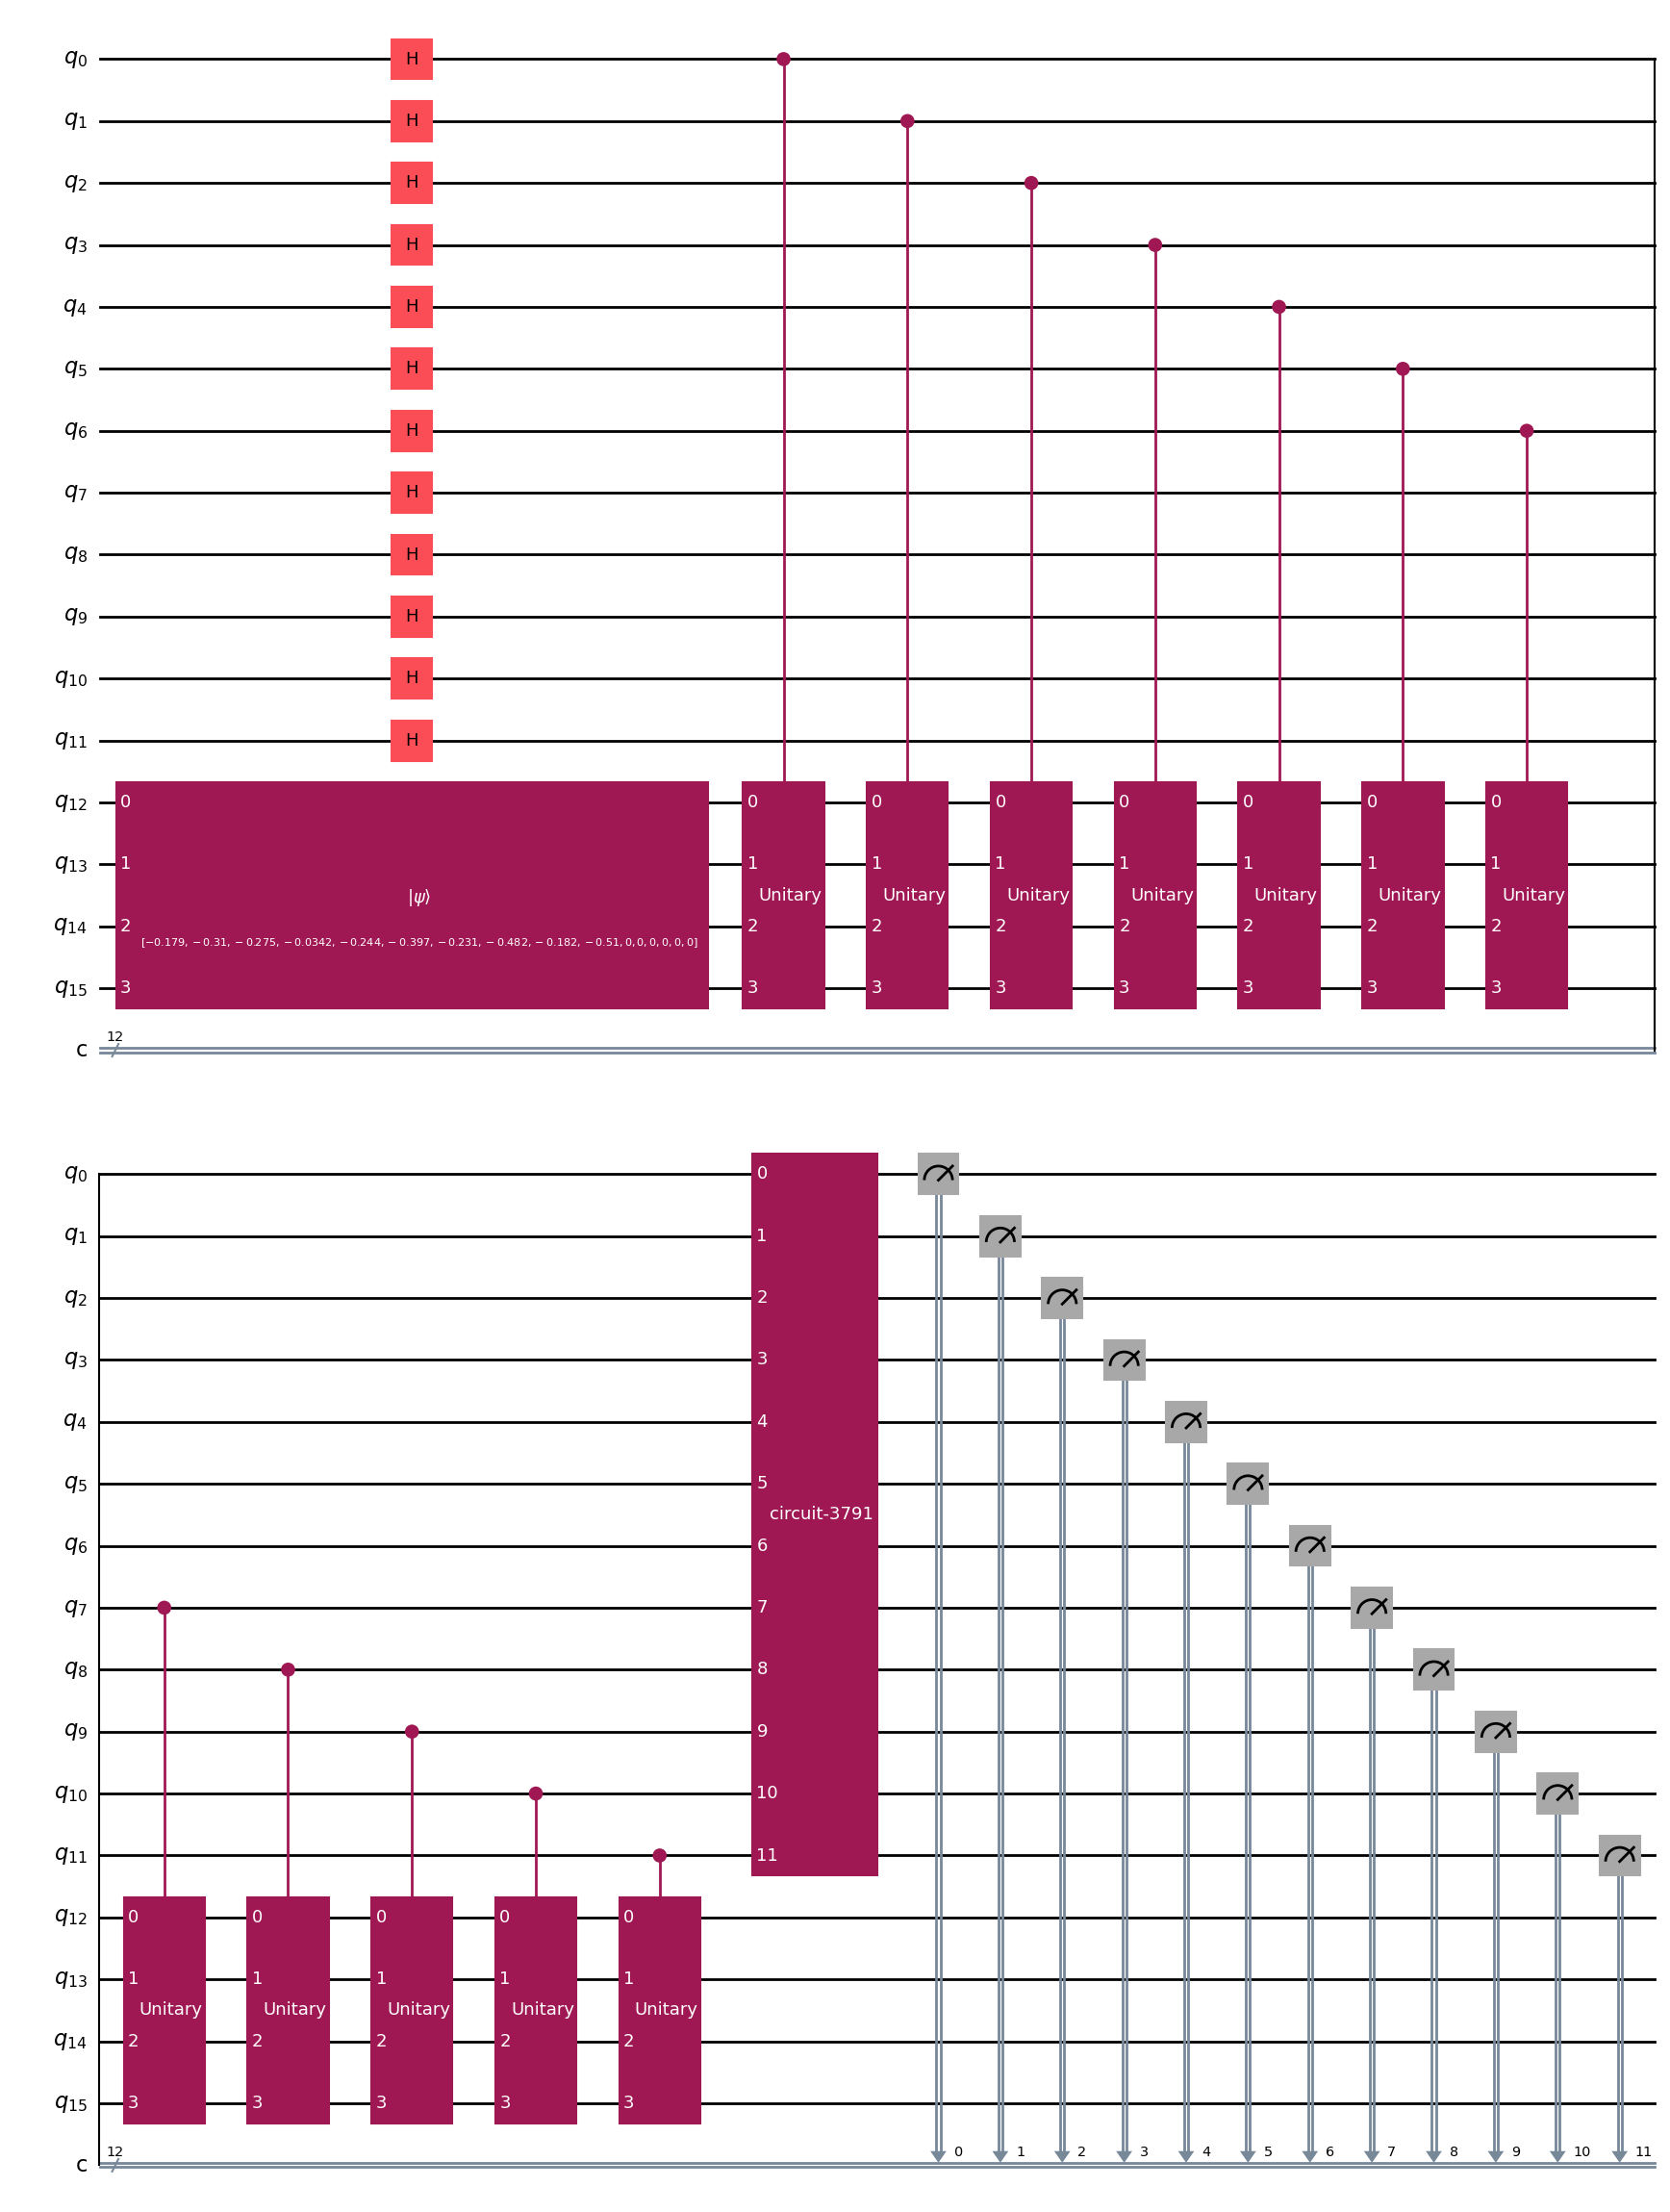

In [13]:
qc.draw('mpl')

## Step 6: Measurement & Phase Estimation

We use Qiskit’s AerSimulator to run the circuit.

**`sim.run().result()`** executes and returns measurement statistics.

**`result.get_counts()`** returns a dictionary of bitstring → frequency.

The most frequent bitstring gives the output of QPE.

We convert it to:
1. A binary integer.
2. An estimated phase:

   $\phi = \frac{\text{decimal}}{2^{n_\text{count}}}$
3. An eigenvalue approximation:

   $\lambda \approx 2\pi \phi$


This is the **quantum-estimated dominant eigenvalue**.


In [10]:
sim = AerSimulator()
tqc = transpile(qc, sim)
result = sim.run(tqc, shots=1024).result()
counts = result.get_counts()

# Estimate phase & corresponding eigenvalue
binary = max(counts, key=counts.get)
decimal = int(binary, 2)
estimated_phi = decimal / 2**n_count
estimated_eigval = estimated_phi * 2 * np.pi

print("\nQPE Results:")
print("Binary result:", binary)
print("Estimated phase:", estimated_phi)
print("Corresponding eigenvalue (approx):", estimated_eigval)


QPE Results:
Binary result: 000000001010
Estimated phase: 0.00244140625
Corresponding eigenvalue (approx): 0.015339807878856412


## Step 7: Computing Asset Contribution and Visualization

The dominant eigenvector describes how each asset contributes to total variance.

- **`np.abs(dominant_eigvec[:n_assets])`** magnitude contributions.
- Normalization so contributions sum to 1.

A pandas DataFrame presents these values, and:

- **`matplotlib.pyplot.barh()`** generates a horizontal bar chart of contribution strengths.

The largest bars indicate assets contributing most to total portfolio risk.

In [11]:
contribution = np.abs(dominant_eigvec[:n_assets])
contribution_norm = contribution / contribution.sum()

risk_df = pd.DataFrame({
    'Asset': tickers,
    'Contribution': contribution_norm
}).sort_values(by='Contribution', ascending=False)

print("\nAsset risk contributions:")
print(risk_df)


Asset risk contributions:
   Asset  Contribution
9   INTC      0.179234
7    IBM      0.169377
5   NVDA      0.139547
1   MSFT      0.108999
2  GOOGL      0.096597
4   TSLA      0.085862
6   META      0.081401
8   ORCL      0.063925
0   AAPL      0.063038
3   AMZN      0.012020


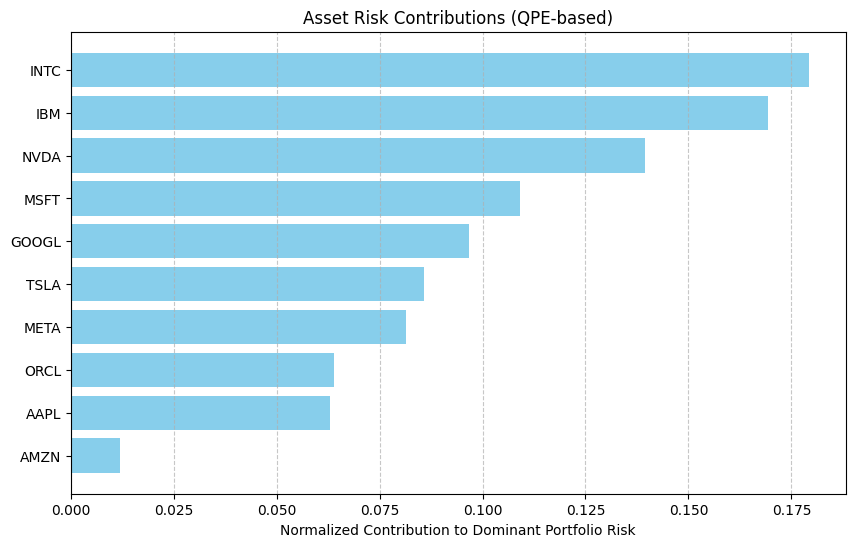

In [12]:
risk_df_sorted = risk_df.sort_values(by='Contribution', ascending=True)

plt.figure(figsize=(10,6))
plt.barh(risk_df_sorted['Asset'], risk_df_sorted['Contribution'], color='skyblue')
plt.xlabel("Normalized Contribution to Dominant Portfolio Risk")
plt.title("Asset Risk Contributions (QPE-based)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()